In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse, coo_matrix, csr_matrix, csc_matrix
from scipy.sparse.linalg import eigsh
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator
from openfermion.linalg import get_sparse_operator,  get_number_preserving_sparse_operator
from openfermion.chem import MolecularData



In [12]:
def indices_with_N_and_Sz0(n_orbital, n_elec):
    """전자수=N 이면서 S_z=0 (interleaved: 짝수=alpha, 홀수=beta)"""
    idx = []
    for s in range(1 << n_orbital):
        if s.bit_count() != n_elec:
            continue
        n_alpha = sum((s >> i) & 1 for i in range(0, n_orbital, 2))  # 0,2,4,...
        n_beta  = sum((s >> i) & 1 for i in range(1, n_orbital, 2))  # 1,3,5,...
        if n_alpha == n_beta:
            idx.append(s)
    return np.array(idx, dtype=int)

def sparse_to_graph(A):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Returns
    -------
    G : nx.Graph
    """
    
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    
    # COO로 변환
    A = A.tocoo(copy=True)

    # 그래프 타입 선택
    G = nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정      
    vals = np.abs(A.data)
    # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
    from collections import defaultdict
    edges = defaultdict(float)
    for i, j, v in zip(A.row, A.col, vals):
        if i == j :
            continue
        key = (min(i, j), max(i, j))
        edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)
            
    print(G)
    return G

### 행렬만들기

In [13]:
C = 1.9220
L = 2.0946
theta = np.deg2rad(94.24)

Co = (0,0,0)
O_1 = (C,0,0)
O_2 = (C*np.cos(theta),C*np.sin(theta),0)
Li = (C+L*np.cos(np.pi-theta),-L*np.sin(np.pi-theta),0)


geometry = [('Co', Co),
            ('O', O_1),
            ('O', O_2),
            ('Li', Li)]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 1
basis = 'sto-3g'

mol_info = MolecularData(geometry, basis, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)
mol = run_pyscf(mol_info, run_scf=1, run_fci=0)
ham_int = mol.get_molecular_hamiltonian()
ham_fci = get_fermion_operator(ham_int) 

In [15]:
H = get_number_preserving_sparse_operator(
fermion_op=ham_fci,
num_qubits=mol.n_qubits,
num_electrons=mol.n_electrons,       # 필수
spin_preserving=True)
H_real = H.real

: 

In [68]:
print(H_real)

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	-1.1166843870853407
  (3, 0)	0.18128880821149593
  (1, 1)	-0.3511901986746764
  (2, 1)	-0.18128880821149593
  (1, 2)	-0.18128880821149593
  (2, 2)	-0.3511901986746764
  (0, 3)	0.18128880821149593
  (3, 3)	0.4592503306687161


In [69]:
H_test = H_real.toarray()
w = np.linalg.eigvals(H_test)   # 고유값만 반환
print(np.sort(w))                   # array([...])

[-1.13727017 -0.53247901 -0.16990139  0.47983612]


### 그래프 표현(무향)

Graph with 4 nodes and 2 edges


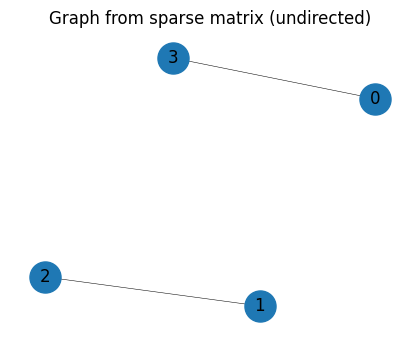

In [71]:
G = sparse_to_graph(H_real)
ccs = list(nx.connected_components(G))

subgraphs = [G.subgraph(S).copy() for S in ccs]

pos = nx.spring_layout(G, seed=0)
edge_w = [d["weight"] for *_, d in G.edges(data=True)]

plt.figure(figsize=(4,3))
nx.draw(G, pos, with_labels=True, node_size=500, width=edge_w)  # weight를 두께로
plt.title("Graph from sparse matrix (undirected)")
plt.show()

### 에너지 계산

In [72]:
sub_mat_idx_g = list(ccs[0])
H_sub_g = H[sub_mat_idx_g, :][:, sub_mat_idx_g]
print(H_sub_g)
H_test_g = H_sub_g.toarray()
e_g = np.linalg.eigvals(H_test_g)   # 고유값만 반환
print(e_g)                   # array([...])

sub_mat_idx_e = list(ccs[1])
H_sub_e = H[sub_mat_idx_e, :][:, sub_mat_idx_e]
print(H_sub_e)
H_test_e = H_sub_e.toarray()
e_e = np.linalg.eigvals(H_test_e)   # 고유값만 반환
print(e_g)      

print("Ground_state_Energy : ", e_g)
print("1st_Excited_Energy : ", e_e)

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	-1.1166843870853407
  (1, 0)	0.18128880821149593
  (0, 1)	0.18128880821149593
  (1, 1)	0.4592503306687161
[-1.13727017  0.47983612]
<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	-0.3511901986746764
  (1, 0)	-0.18128880821149593
  (0, 1)	-0.18128880821149593
  (1, 1)	-0.3511901986746764
[-1.13727017  0.47983612]
Ground_state_Energy :  [-1.13727017  0.47983612]
1st_Excited_Energy :  [-0.16990139 -0.53247901]
